#### 1.11.4 梯度提升树（GradientTree Boosting)
GBRT是一个准确率高、有效的算法，可以解决回归和分类问题。该模型被广泛应用到各个领域，包括网络搜索排名。

▲GBRT的优点包括：

可以对混合数据类型进行自然处理（非均值特征）
预测能力
对输出空间中的异常数据具有鲁棒性（通过鲁棒损失函数）

▲GBRT的缺点包括：

由于其序列性，很难进行并行运算

##### 1.11.4.1分类（classification)

In [2]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

In [4]:
print(X_train.shape, X_test.shape)

(2000, 10) (10000, 10)


In [5]:
# 在数据量大的时候，建议使用RandomForestClassifier代替GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0,
                                 max_depth=1,
                                 random_state=0)  # 100个弱学习器数量，最大深度控制树的大小，学习率控制过拟合．
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [6]:
clf.score(X_test, y_test)

0.913

##### 1.11.4.2 回归（Regression)

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

In [8]:
X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)
X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]
print(X_train.shape, X_test.shape)

(200, 10) (1000, 10)


In [11]:
est = GradientBoostingRegressor(n_estimators=100, 
                                 learning_rate=0.1,
                                 max_depth=1, 
                                 random_state=0,
                                 loss='ls')  # 最小平方损失,默认
est.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
est.score(X_test, y_test)  # 准确率

0.8058912110043196

In [13]:
mean_squared_error(y_test, est.predict(X_test))  # 均方差

5.009154859960321

接下来展示使用最小平方损失、500个基学习器的梯度提升回归对波士顿房价的拟合。每次迭代的训练样本的错误率保存在模型的train_score_中。测试样本的错误率可以通过staged_predict方法获得，该方法返回一个生成器，用于生成每个阶段的预测。像这样的曲线可以通过提前停止来确定树的最优数量，即参数：n_estimators。特征的重要程度，可通过fearture_importances_property获得。

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [15]:
# 加载数据
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0]*0.9)

X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [16]:
print(X_train.shape, X_test.shape)

(455, 13) (51, 13)


In [17]:
# 拟合回归模型
params = {'n_estimators': 500,
          'max_depth': 4, 
          'min_samples_split': 2, 
          'learning_rate': 0.01, 
          'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f"%(mse))

MSE: 6.4696


In [19]:
# 下降曲线
test_score = np.zeros((params['n_estimators'], ), dtype=np.float64)

In [21]:
for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)  # LS

Text(0, 0.5, 'Deviance')

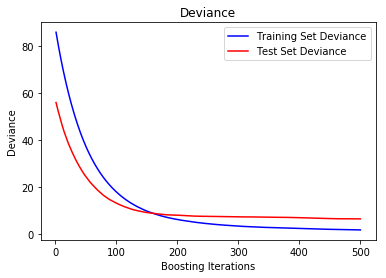

In [22]:
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators'])+1, clf.train_score_, 'b-', label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators'])+1, test_score, 'r-', label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

Text(0.5, 1.0, 'Variable Importance')

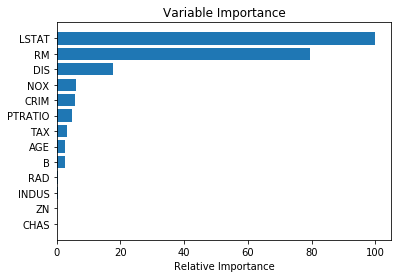

In [23]:
# 重要特征
feature_importance = clf.feature_importances_
feature_importance = 100.0*(feature_importance/feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])+0.5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')